<a href="https://colab.research.google.com/github/6058ah/BusinessCapstone/blob/master/%EB%94%A5%EB%9F%AC%EB%8B%9D%EA%B3%BC_%ED%85%8D%EC%8A%A4%ED%8A%B8%EB%A7%88%EC%9D%B4%EB%8B%9D%EC%9D%84_%ED%86%B5%ED%95%9C_ETF_%EB%A7%A4%EB%A7%A4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM과 텍스트 마이닝을 통한 ETF 주가 예측

## Case 1. 과거 주가 데이터로만 학습

###데이터 준비

In [1]:
!pip install pykrx

     |████████████████████████████████| 81kB 5.1MB/s 
     |████████████████████████████████| 61kB 6.5MB/s 
     |████████████████████████████████| 256kB 38.2MB/s 


In [2]:
from pykrx import stock
import requests
import json
from pandas.io.json import json_normalize
import pandas as pd

tickers = stock.get_etf_ticker_list('20210430')
tickers = pd.DataFrame(tickers,columns = ['종목코드'])

url = 'https://finance.naver.com/api/sise/etfItemList.nhn'
json_data = json.loads(requests.get(url).text)
df = json_normalize(json_data['result']['etfItemList'])
df=df[['itemcode','itemname']]
df=df.rename(columns={'itemcode':'종목코드','itemname':'종목명'})

etf = pd.merge(left = tickers, right = df, how = 'left', on= '종목코드')
battery_etf = etf[etf['종목명'].str.contains('2차전지')]
battery_etf = battery_etf.drop(index=122)
battery_etf

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  if sys.path[0] == '':


,종목코드,종목명
116,305540,TIGER 2차전지테마
240,305720,KODEX 2차전지산업


In [3]:
stocks = dict()
for a, b in battery_etf[['종목명','종목코드']].itertuples(index=False):
  price = stock.get_etf_ohlcv_by_date("20180912","20210430",b)
  stocks[a]=price['종가'].values[:].tolist()
prices = pd.DataFrame(stocks)
prices.index = price.index
prices

,TIGER 2차전지테마,KODEX 2차전지산업
날짜,,
2018-09-12,9805,9810
2018-09-13,9805,9775
2018-09-14,9915,9935
2018-09-17,10015,9990
2018-09-18,10220,10170
...,...,...
2021-04-26,18705,19720
2021-04-27,18600,19795
2021-04-28,18250,19500


In [4]:
Tiger = prices.iloc[:,0]
Kodex = prices.iloc[:,1]

###LSTM

In [5]:
import numpy as np # linear algebra
import matplotlib.pyplot as plt # data visualization
import os
import warnings
warnings.filterwarnings(action='ignore')
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)

# Library for Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error

findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


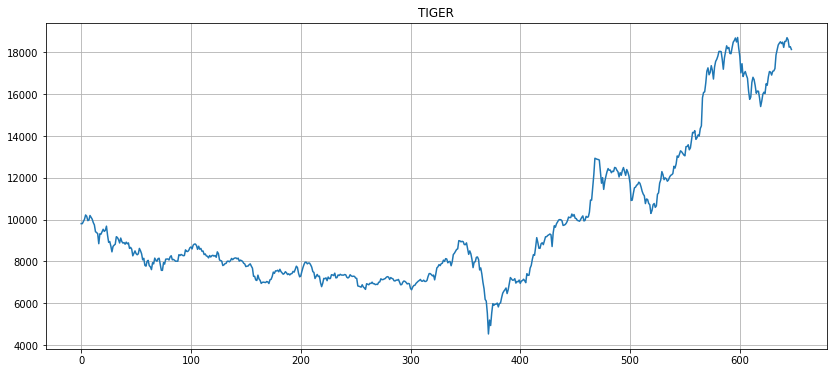

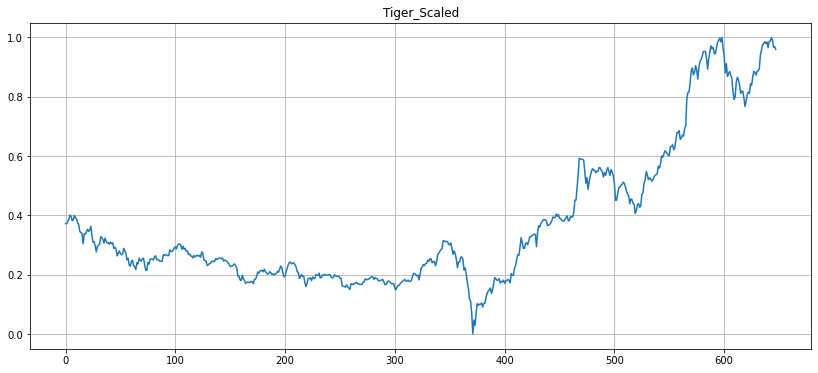

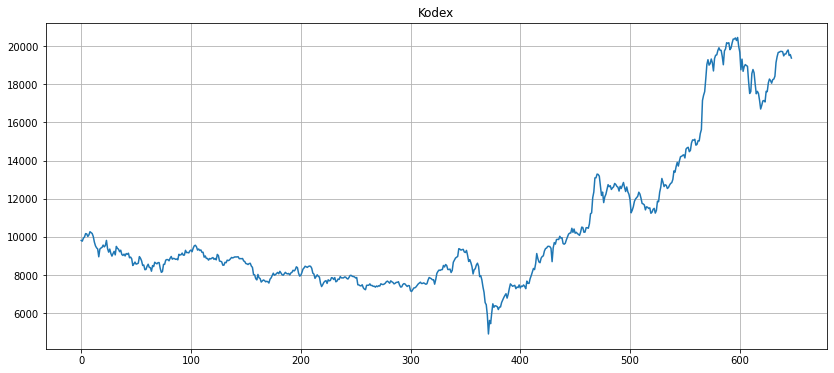

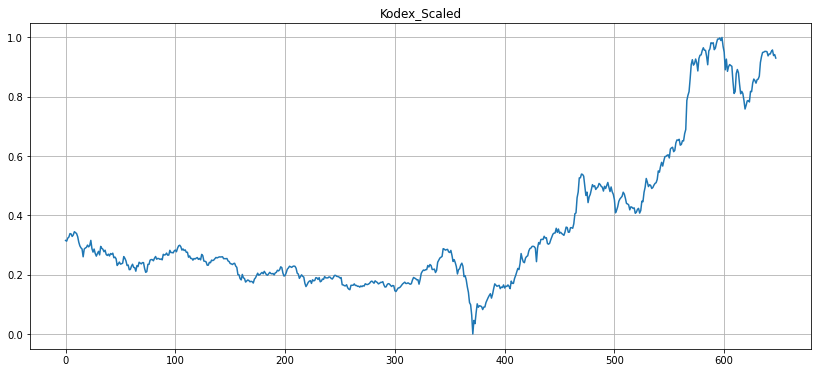

In [6]:
Tiger = np.array(Tiger).reshape(-1,1)
plt.figure(figsize=(14,6))
plt.title("TIGER")
plt.grid()
plt.plot(Tiger)

sc = MinMaxScaler()
TigerSC = sc.fit_transform(Tiger)
plt.figure(figsize=(14,6))
plt.title("Tiger_Scaled")
plt.grid()
plt.plot(TigerSC)

Kodex = np.array(Kodex).reshape(-1,1)
plt.figure(figsize=(14,6))
plt.title("Kodex")
plt.grid()
plt.plot(Kodex)

sc = MinMaxScaler()
KodexSC = sc.fit_transform(Kodex)
plt.figure(figsize=(14,6))
plt.title("Kodex_Scaled")
plt.grid()
plt.plot(KodexSC)

In [7]:
X = []
y = []
for i in range(1, len(TigerSC)):
    X.append(TigerSC[i-1:i, 0])
    y.append(TigerSC[i,0])
X, y = np.array(X), np.array(y) # array()함수의 인자로 리스트를 넣어 Numpy 배열을 생성시킴
print(X.shape, y.shape)

(647, 1) (647,)


In [8]:
X_train = X[:500,:]
X_test = X[500:,:]

y_train = y[:500]
y_test = y[500:]    

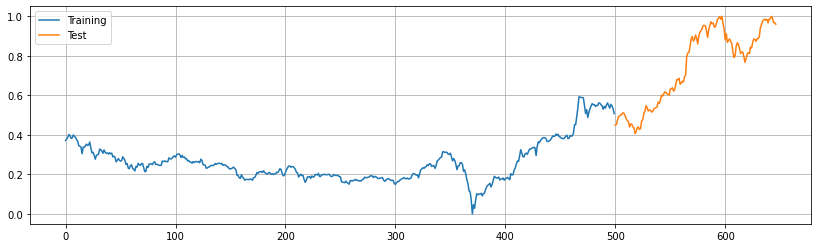

In [9]:
plt.figure(figsize=(14,4))
plt.plot(range(500),y_train)
plt.plot(range(500, len(y)), y_test)
plt.legend(["Training", "Test"])
plt.grid()

In [10]:
X_train = X_train.reshape(-1,1,1)
X_test = X_test.reshape(-1,1,1)

In [12]:
regressor = Sequential()

regressor.add(LSTM(units=32, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=32, return_sequences=True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=32, return_sequences=True))
regressor.add(Dropout(0.5))

regressor.add(LSTM(units=32))
regressor.add(Dropout(0.5))

regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='adam', loss='mean_absolute_error')
# Fitting to the training set
regressor.fit(X_train, y_train, epochs=30, batch_size=30)

Epoch 1/30
17/17 [==============================] - 6s 5ms/step - loss: 0.2472
Epoch 2/30
17/17 [==============================] - 0s 5ms/step - loss: 0.1818
Epoch 3/30
17/17 [==============================] - 0s 5ms/step - loss: 0.1051
Epoch 4/30
17/17 [==============================] - 0s 4ms/step - loss: 0.0800
Epoch 5/30
17/17 [==============================] - 0s 5ms/step - loss: 0.0848
Epoch 6/30
17/17 [==============================] - 0s 6ms/step - loss: 0.0798
Epoch 7/30
17/17 [==============================] - 0s 5ms/step - loss: 0.0790
Epoch 8/30
17/17 [==============================] - 0s 6ms/step - loss: 0.0816
Epoch 9/30
17/17 [==============================] - 0s 5ms/step - loss: 0.0759
Epoch 10/30
17/17 [==============================] - 0s 5ms/step - loss: 0.0769
Epoch 11/30
17/17 [==============================] - 0s 5ms/step - loss: 0.0672
Epoch 12/30
17/17 [==============================] - 0s 5ms/step - loss: 0.0668
Epoch 13/30
17/17 [==============================

###결과

In [13]:
regressor.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 1, 32)             4352      
_________________________________________________________________
dropout_4 (Dropout)          (None, 1, 32)             0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 1, 32)             8320      
_________________________________________________________________
dropout_5 (Dropout)          (None, 1, 32)             0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 1, 32)             8320      
_________________________________________________________________
dropout_6 (Dropout)          (None, 1, 32)             0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 32)               

In [15]:
y_pred = regressor.predict(X_test)

Text(0, 0.5, 'Price')

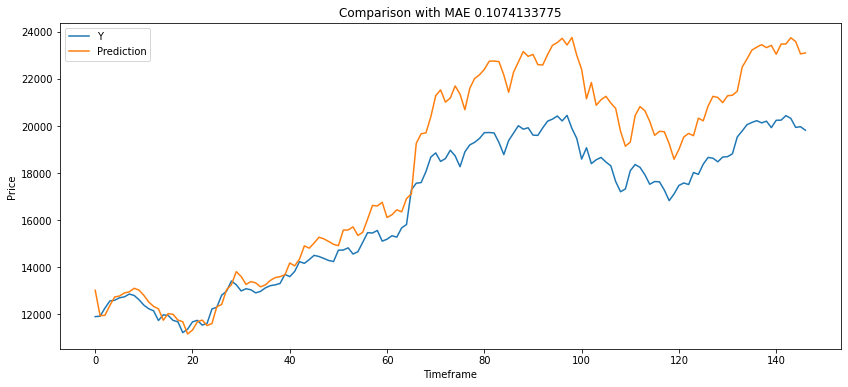

In [16]:
plt.figure(figsize=(14,6))
plt.plot(sc.inverse_transform(y_test.reshape(-1,1)))
plt.plot(sc.inverse_transform(y_pred.reshape(-1,1)))
plt.title("Comparison with MAE {0:0.10f}".format(mean_absolute_error(y_test, y_pred)))
plt.legend(["Y", "Prediction"])
plt.xlabel("Timeframe")
plt.ylabel("Price")

In [17]:
err_model1 = regressor.evaluate(X_test, y_test, batch_size=30)
models = pd.DataFrame({
    'Model': ['LSTM with one sequence'],
    'Score': [err_model1]})
models.sort_values(by='Score', ascending=True)

5/5 [==============================] - 1s 3ms/step - loss: 0.1074


,Model,Score
0,LSTM with one sequence,0.107413


## Case 2. 기술적 지표 추가

###데이터 준비

In [18]:
def get_macd(df, short=12, long=26, t=9):
  df = pd.DataFrame(df)
  ma_12 = df['종가'].ewm(span=12).mean()
  ma_26 = df['종가'].ewm(span=26).mean()
  macd = ma_12 - ma_26
  macds = macd.ewm(span=9).mean()
  macdo = macd - macds
  df = df.assign(macd=macd, macds=macds, macdo=macdo).dropna()
  return df


In [19]:
!pip install ta

  Created wheel for ta: filename=ta-0.7.0-cp37-none-any.whl size=28716 sha256=76ae6ac329bd9e86427303f69f48ef7ce8a48db299b245e5900f2ead685a7f9b
  Stored in directory: /root/.cache/pip/wheels/dd/88/30/de9553fb54a474eb7480b937cdbb140bdda613d29cf4da7994
Successfully built ta


In [20]:
from ta.utils import dropna
from ta.volatility import BollingerBands
#Tiger
Tiger = stock.get_etf_ohlcv_by_date("20180912","20210430",'305540')
Tiger = get_macd(Tiger)

# Clean NaN values
Tiger = dropna(Tiger)

# Initialize Bollinger Bands Indicator
indicator_bb = BollingerBands(close=Tiger["종가"], window=20, window_dev=2)

# Add Bollinger Bands features
Tiger['bb_bbm'] = indicator_bb.bollinger_mavg()
Tiger['bb_bbh'] = indicator_bb.bollinger_hband()
Tiger['bb_bbl'] = indicator_bb.bollinger_lband()

Tiger = Tiger.dropna(axis=0)

Tiger.drop(['NAV','시가','고가','저가','거래량','거래대금','기초지수'],axis=1,inplace=True)
Tiger

,종가,macd,macds,macdo,bb_bbm,bb_bbh,bb_bbl
날짜,,,,,,,
2018-10-18,9435,-107.845213,-99.374469,-8.470744,9706.50,10459.859808,8953.140192
2018-10-19,9485,-97.964010,-99.090702,1.126692,9685.00,10437.874492,8932.125508
2018-10-22,9685,-75.383826,-94.326830,18.943004,9668.50,10406.030338,8930.969662
2018-10-23,9250,-87.173215,-92.890681,5.717467,9620.00,10333.260121,8906.739879
2018-10-24,8910,-119.202672,-98.169032,-21.033639,9557.50,10289.357227,8825.642773
...,...,...,...,...,...,...,...
2021-04-26,18705,512.203780,425.322976,86.880804,17723.00,19259.253234,16186.746766
2021-04-27,18600,506.255144,441.509410,64.745734,17828.00,19301.313952,16354.686048
2021-04-28,18250,467.905015,446.788531,21.116484,17919.00,19254.015356,16583.984644


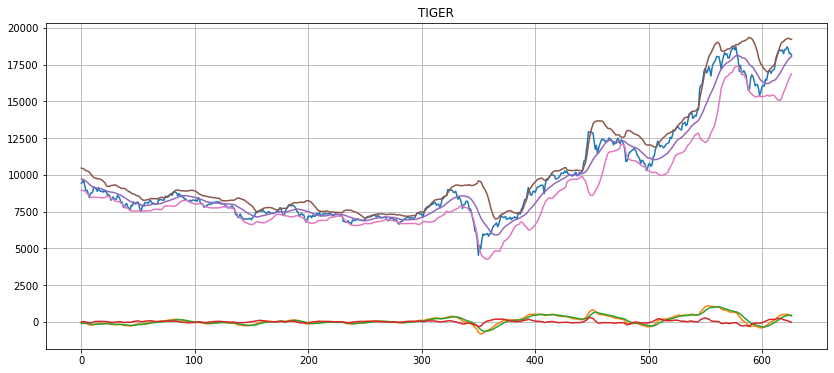

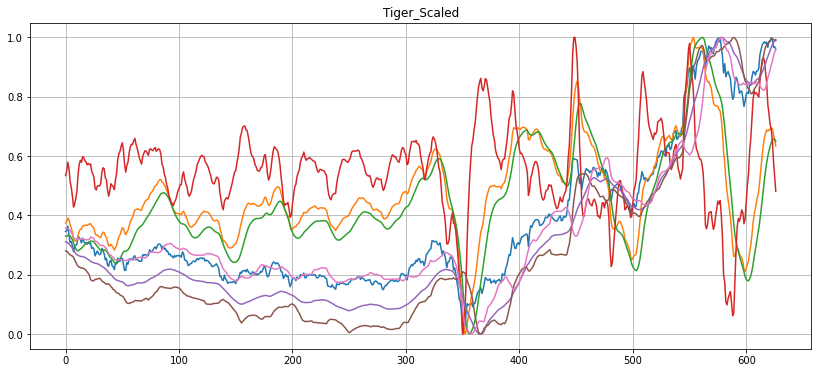

In [21]:
Tiger = np.array(Tiger).reshape(-1,7)
plt.figure(figsize=(14,6))
plt.title("TIGER")
plt.grid()
plt.plot(Tiger)

sc = MinMaxScaler()
TigerSC = sc.fit_transform(Tiger)
plt.figure(figsize=(14,6))
plt.title("Tiger_Scaled")
plt.grid()
plt.plot(TigerSC)

In [22]:
X = []
y = []
for i in range(1, len(TigerSC)):
    X.append(TigerSC[i-1:i, 0:7])
    y.append(TigerSC[i,0])
X, y = np.array(X), np.array(y) # array()함수의 인자로 리스트를 넣어 Numpy 배열을 생성시킴
print(X.shape, y.shape)

(626, 1, 7) (626,)


In [23]:
X_train = X[:500,:]
X_test = X[500:,:]

y_train = y[:500]
y_test = y[500:]    

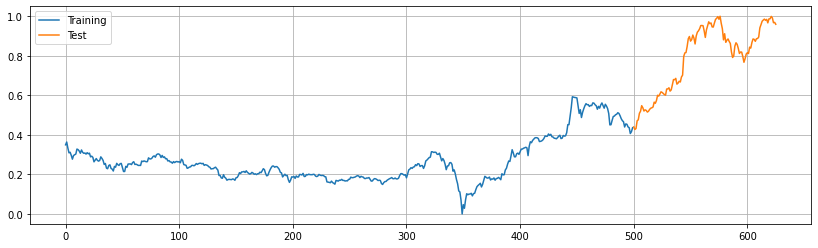

In [24]:
plt.figure(figsize=(14,4))
plt.plot(range(500),y_train)
plt.plot(range(500, len(y)), y_test)
plt.legend(["Training", "Test"])
plt.grid()

In [25]:
X_train = X_train.reshape(-1,1,7)
X_test = X_test.reshape(-1,1,7)

###LSTM

In [26]:
regressor = Sequential()

regressor.add(LSTM(units=32, return_sequences=True, input_shape=(X_train.shape[1],7)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=32, return_sequences=True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=32, return_sequences=True))
regressor.add(Dropout(0.5))

regressor.add(LSTM(units=32))
regressor.add(Dropout(0.5))

regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='adam', loss='mean_absolute_error')
# Fitting to the training set
regressor.fit(X_train, y_train, epochs=30, batch_size=30)

Epoch 1/30
17/17 [==============================] - 6s 5ms/step - loss: 0.2551
Epoch 2/30
17/17 [==============================] - 0s 5ms/step - loss: 0.2042
Epoch 3/30
17/17 [==============================] - 0s 5ms/step - loss: 0.1145
Epoch 4/30
17/17 [==============================] - 0s 5ms/step - loss: 0.0853
Epoch 5/30
17/17 [==============================] - 0s 5ms/step - loss: 0.0780
Epoch 6/30
17/17 [==============================] - 0s 5ms/step - loss: 0.0757
Epoch 7/30
17/17 [==============================] - 0s 5ms/step - loss: 0.0640
Epoch 8/30
17/17 [==============================] - 0s 5ms/step - loss: 0.0639
Epoch 9/30
17/17 [==============================] - 0s 5ms/step - loss: 0.0547
Epoch 10/30
17/17 [==============================] - 0s 5ms/step - loss: 0.0518
Epoch 11/30
17/17 [==============================] - 0s 5ms/step - loss: 0.0479
Epoch 12/30
17/17 [==============================] - 0s 5ms/step - loss: 0.0511
Epoch 13/30
17/17 [==============================

###결과

In [27]:
y_pred = regressor.predict(X_test)

In [28]:
regressor.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 1, 32)             5120      
_________________________________________________________________
dropout_8 (Dropout)          (None, 1, 32)             0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 1, 32)             8320      
_________________________________________________________________
dropout_9 (Dropout)          (None, 1, 32)             0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 1, 32)             8320      
_________________________________________________________________
dropout_10 (Dropout)         (None, 1, 32)             0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 32)               

Text(0, 0.5, 'Price')

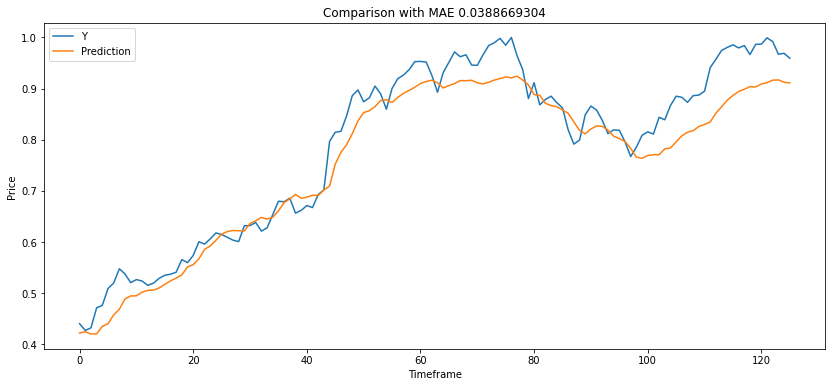

In [29]:
plt.figure(figsize=(14,6))
plt.plot(y_test)
plt.plot(y_pred)
plt.title("Comparison with MAE {0:0.10f}".format(mean_absolute_error(y_test, y_pred)))
plt.legend(["Y", "Prediction"])
plt.xlabel("Timeframe")
plt.ylabel("Price")

In [30]:
err_model2 = regressor.evaluate(X_test, y_test, batch_size=30)

models = pd.DataFrame({
    'Model': ['LSTM with Only Close', 'LSTM with Close, Technical Analysis'],
    'Score': [err_model1,err_model2]})
models.sort_values(by='Score', ascending=True)

5/5 [==============================] - 1s 3ms/step - loss: 0.0389


,Model,Score
1,"LSTM with Close, Technical Analysis",0.038867
0,LSTM with Only Close,0.107413


##Case 3. 2차산업관련 뉴스 감성 점수 추가

###데이터 준비

In [31]:
!pip install xlsxwriter

     |████████████████████████████████| 153kB 7.4MB/s 


In [32]:
#Tiger
Tiger = stock.get_etf_ohlcv_by_date("20180912","20210430",'305540')
Tiger = get_macd(Tiger)

# Clean NaN values
Tiger = dropna(Tiger)

# Initialize Bollinger Bands Indicator
indicator_bb = BollingerBands(close=Tiger["종가"], window=20, window_dev=2)

# Add Bollinger Bands features
Tiger['bb_bbm'] = indicator_bb.bollinger_mavg()
Tiger['bb_bbh'] = indicator_bb.bollinger_hband()
Tiger['bb_bbl'] = indicator_bb.bollinger_lband()

Tiger = Tiger.dropna(axis=0)

Tiger.drop(['NAV','시가','고가','저가','거래량','거래대금','기초지수'],axis=1,inplace=True)
Tiger

,종가,macd,macds,macdo,bb_bbm,bb_bbh,bb_bbl
날짜,,,,,,,
2018-10-18,9435,-107.845213,-99.374469,-8.470744,9706.50,10459.859808,8953.140192
2018-10-19,9485,-97.964010,-99.090702,1.126692,9685.00,10437.874492,8932.125508
2018-10-22,9685,-75.383826,-94.326830,18.943004,9668.50,10406.030338,8930.969662
2018-10-23,9250,-87.173215,-92.890681,5.717467,9620.00,10333.260121,8906.739879
2018-10-24,8910,-119.202672,-98.169032,-21.033639,9557.50,10289.357227,8825.642773
...,...,...,...,...,...,...,...
2021-04-26,18705,512.203780,425.322976,86.880804,17723.00,19259.253234,16186.746766
2021-04-27,18600,506.255144,441.509410,64.745734,17828.00,19301.313952,16354.686048
2021-04-28,18250,467.905015,446.788531,21.116484,17919.00,19254.015356,16583.984644


In [ ]:
#dates = [date.strftime("%Y.%m.%d") for date in Tiger.index]

In [105]:
from bs4 import BeautifulSoup
from datetime import datetime
import requests
import pandas as pd
import re

title_text=[]
contents_text=[]
dates_text = []
#result=[]

#엑셀로 저장하기 위한 변수
RESULT_PATH ='/content/drive'  #결과 저장할 경로

#날짜 범위 리스트로 만들기
def date_range(start, end):
    start = datetime.strptime(start, "%Y.%m.%d")
    end = datetime.strptime(end, "%Y.%m.%d")
    dates = [date.strftime("%Y.%m.%d") for date in pd.date_range(start, periods=(end-start).days+1)]
    return dates

#def contents_cleansing(contents):
#    first_cleansing_contents = re.sub('<dl>.*?</a> </div> </dd> <dd>', '',str(contents)).strip()  #앞에 필요없는 부분 제거
#    second_cleansing_contents = re.sub('<ul class="relation_lst">.*?</dd>', '', first_cleansing_contents).strip()#뒤에 필요없는 부분 제거 (새끼 기사)
#    third_cleansing_contents = re.sub('<.+?>', '', second_cleansing_contents).strip()
#    contents_text.append(third_cleansing_contents)
#    #print(contents_text)

#크롤링 시작
def crawler(query,s_date,e_date):
  dates= [date.strftime("%Y.%m.%d") for date in Tiger.index]
  page_num = [1,11,21,31,41]
  #maxpage_t =41
  for x in dates:
    #print(x)
    for page_number in page_num:
      ds = x.replace(".","")
      de = ds
      url = "https://search.naver.com/search.naver?where=news&query=" + query + "&sort=0"+"&ds=" + x + "&de=" + x + "&nso=so%3Ar%2Cp%3Afrom" + ds + "to" + de + "%2Ca%3A&start=" + str(page_number)
      #url = "https://search.naver.com/search.naver?&where=news&query={0}&sm=tab_pge&sort={1}&photo=0&field=0&reporter_article=&pd=3&ds={2}&de={2}&docid=&nso=so:r,p:,a:all&mynews=1&cluster_rank=238&start={3}&refresh_start=0".format(query,sort,x,str(page_num))
      #print(url)
      response = requests.get(url)
      html = response.text

      #뷰티풀소프의 인자값 지정
      soup = BeautifulSoup(html, 'html.parser')

      #뉴스 날짜
#      bbs = soup.find_all('span', 'info')
#      for bb in bbs:
#        t = bb.text
#        dates_text.append(t)
#      search = "면"
#      for word in dates_text:
#        if search in word: 
#          dates_text.remove(word)


      #<a>태그에서 제목과 링크주소 (a 태그 중 class 명이 news_tit인 것)
      atags = soup.find_all('a', 'news_tit')
      for atag in atags:
        title = atag.get('title')
        title_text.append(title)     #제목
        dates_text.append(x)
            
      #본문요약본 (a 태그 중 class 명이 api_txt_lines dsc_txt_wrap인 것)
      #contents_lists = soup.find_all('a','api_txt_lines dsc_txt_wrap')
      #for contents_list in contents_lists:
      #  contents_cleansing(contents_list) #본문요약 정제화


      #모든 리스트 딕셔너리형태로 저장
      #result= {"Date":dates_text,"title":title_text}
      df1 = pd.DataFrame(dates_text)
      df2 = pd.DataFrame(title_text) #df로 변환
      result = pd.concat([df1,df2],axis=1)
      #print(result)

  outputFileName = '{0}~{1} {2} 관련 뉴스.xlsx'.format(s_date.replace(".",""), e_date.replace(".",""), query)
  writer = pd.ExcelWriter(outputFileName, engine='xlsxwriter')
  result.to_excel(writer, sheet_name= '{0}~{1} {2} 뉴스'.format(s_date.replace(".",""), e_date.replace(".",""), query))
  writer.save()

#메인함수
def main():
    info_main = input("="*50+"\n"+"입력 형식에 맞게 입력해주세요."+"\n"+" 시작하시려면 Enter를 눌러주세요."+"\n"+"="*50)
    query = input("검색어 입력: ") #네이버, 부동산...
    s_date = input("시작날짜 입력(예시:2019.01.01):")
    e_date = input("끝날짜 입력:")
    crawler(query,s_date, e_date)

In [106]:
main()

입력 형식에 맞게 입력해주세요.
 시작하시려면 Enter를 눌러주세요.
검색어 입력: 2차전지산업
시작날짜 입력(예시:2019.01.01):2018.10.18
끝날짜 입력:2021.04.30


In [ ]:
!pip install konlpy

In [108]:
!git clone https://github.com/FinanceData/corpus.git

Cloning into 'corpus'...
remote: Enumerating objects: 11, done.
remote: Total 11 (delta 0), reused 0 (delta 0), pack-reused 11
Unpacking objects: 100% (11/11), done.


In [109]:
from konlpy.tag import Kkma

engine = Kkma()
polarity_dic = pd.read_csv('corpus/kosac/polarity.csv')
polarity_dic.set_index('ngram', inplace=True)

def polarity_score(text):
    pos_tags = engine.pos(text)

    # n-gram
    unigram = ['/'.join(p) for p in pos_tags]
    bigram = [';'.join(z) for z in zip(unigram, unigram[1:])]
    trigram = [';'.join(z) for z in zip(*[unigram[i:] for i in range(3)])]
    
    p_score = 0
    # polarity score = (p-n) / (p+n)
    for ngram in [unigram, bigram, trigram]:
        cond = polarity_dic.index.isin(ngram)
        s = polarity_dic.loc[cond, :].sum()
        if s['POS'] + s['NEG'] > 0: # div 0 방지
            p_score += (s['POS'] - s['NEG']) / (s['POS'] + s['NEG'])
    return p_score

In [111]:
news = pd.read_excel('/content/20181018~20210430 2차전지산업 관련 뉴스.xlsx')

In [112]:
news.columns = ['Count', 'Date', 'Title']
news.head()

,Count,Date,Title
0,0,2018.10.18,"대보마그네틱 내달 코스닥 입성…""2차전지 수요로 고성장"""
1,1,2018.10.18,"삼성SDI LG화학 SK이노베이션, 중국 전기차배터리 구조조정 수혜"
2,2,2018.10.18,극우 현상? 한국도 다르지 않다
3,3,2018.10.18,"'글로벌 EMF 1위' 대보마그네틱, 내달 코스닥 상장 앞둬"
4,4,2018.10.18,"창원상의, 2018 창원지역상장사 IR 개최"


In [113]:
news.loc[:,'Title']

0                          대보마그네틱 내달 코스닥 입성…"2차전지 수요로 고성장"
1                    삼성SDI LG화학 SK이노베이션, 중국 전기차배터리 구조조정 수혜
2                                        극우 현상? 한국도 다르지 않다
3                        '글로벌 EMF 1위' 대보마그네틱, 내달 코스닥 상장 앞둬
4                                 창원상의, 2018 창원지역상장사 IR 개최
                               ...                        
21400     [공석환의 주식시황] “공매도 걱정? 최근 10거래일 연기금 매수 많은 종목 따르는게"
21401    국민의힘 새 사령탑 김기현 신임 원내대표는 누구? | 한때 대선 잠룡.... 울산시...
21402                      SNE리서치, 전기차용 차세대 배터리 온라인 세미나 연다
21403               [전문가 칼럼] 스마트공장을 위한 현장의 로봇 적용 엔지니어링(3편)
21404                   LG상사, 1분기 영업익 1133억원 기록 '분기 사상 최대'
Name: Title, Length: 21405, dtype: object

In [114]:
news_scores = []
for i in news.loc[:,'Title']:
  news_score = polarity_score(i)
  #print(news_score)
  news_scores.append(news_score)

In [115]:
news_scores_df = pd.DataFrame(data = news_scores, columns=['Score'])

In [116]:
result = pd.concat([news,news_scores_df],axis=1)
result.head()

,Count,Date,Title,Score
0,0,2018.10.18,"대보마그네틱 내달 코스닥 입성…""2차전지 수요로 고성장""",1.000000
1,1,2018.10.18,"삼성SDI LG화학 SK이노베이션, 중국 전기차배터리 구조조정 수혜",-0.538824
2,2,2018.10.18,극우 현상? 한국도 다르지 않다,-0.094488
3,3,2018.10.18,"'글로벌 EMF 1위' 대보마그네틱, 내달 코스닥 상장 앞둬",0.000000
4,4,2018.10.18,"창원상의, 2018 창원지역상장사 IR 개최",1.000000


In [117]:
dr = [date.strftime("%Y.%m.%d") for date in Tiger.index]
mean_text = []
for i in dr:
  Smean = result.loc[result['Date']==i,'Score'].mean()
  mean_text.append(Smean)

df1= pd.DataFrame(dr)
df2= pd.DataFrame(mean_text)

date_mean_score = pd.concat([df1,df2],axis=1)

In [118]:
date_mean_score.columns = ['Date','Score']
type(date_mean_score)

pandas.core.frame.DataFrame

In [142]:
date_mean_score.to_excel('2차전지산업 관련 뉴스 감성점수.xlsx')

TypeError: ignored

In [124]:
date_mean_score = date_mean_score.drop('Date', axis=1)

In [125]:
date_mean_score

,Score
0,0.304989
1,0.139543
2,0.004679
3,0.140723
4,0.397520
...,...
622,0.158912
623,0.192055
624,0.426701
625,0.282957


In [140]:
Tiger.to_excel('Tiger.xlsx')

In [143]:
Tiger = pd.read_excel('/content/Tiger.xlsx', index_col=0)
Tiger

,종가,macd,macds,macdo,bb_bbm,bb_bbh,bb_bbl,Score
날짜,,,,,,,,
2018-10-18,9435,-107.845213,-99.374469,-8.470744,9706.50,10459.859808,8953.140192,0.304989
2018-10-19,9485,-97.964010,-99.090702,1.126692,9685.00,10437.874492,8932.125508,0.139543
2018-10-22,9685,-75.383826,-94.326830,18.943004,9668.50,10406.030338,8930.969662,0.004679
2018-10-23,9250,-87.173215,-92.890681,5.717467,9620.00,10333.260121,8906.739879,0.140723
2018-10-24,8910,-119.202672,-98.169032,-21.033639,9557.50,10289.357227,8825.642773,0.397520
...,...,...,...,...,...,...,...,...
2021-04-26,18705,512.203780,425.322976,86.880804,17723.00,19259.253234,16186.746766,0.158912
2021-04-27,18600,506.255144,441.509410,64.745734,17828.00,19301.313952,16354.686048,0.192055
2021-04-28,18250,467.905015,446.788531,21.116484,17919.00,19254.015356,16583.984644,0.426701


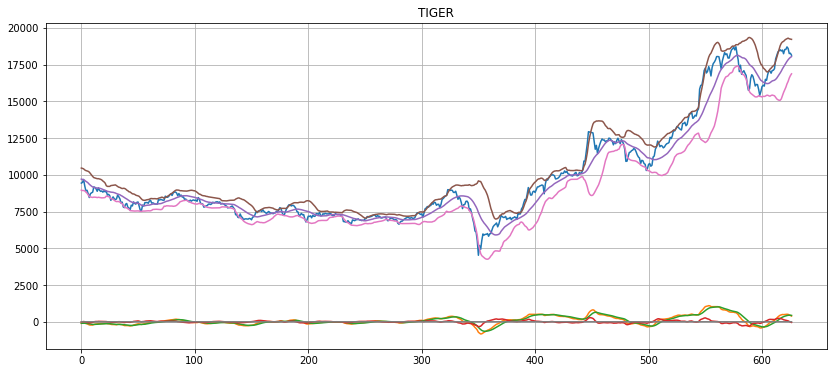

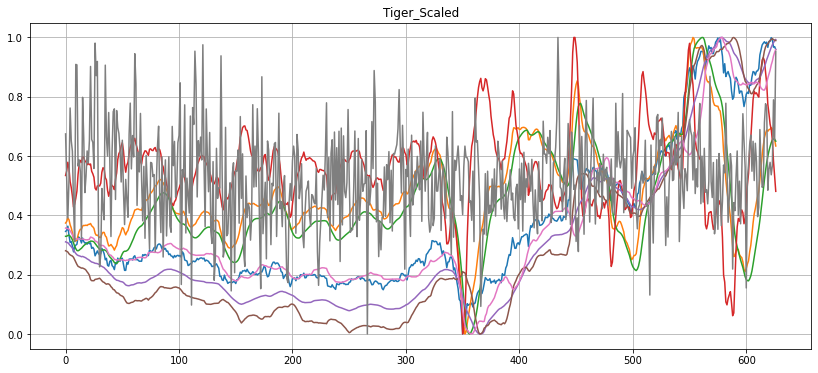

In [144]:
Tiger = np.array(Tiger).reshape(-1,8)
plt.figure(figsize=(14,6))
plt.title("TIGER")
plt.grid()
plt.plot(Tiger)

sc = MinMaxScaler()
TigerSC = sc.fit_transform(Tiger)
plt.figure(figsize=(14,6))
plt.title("Tiger_Scaled")
plt.grid()
plt.plot(TigerSC)

In [145]:
X = []
y = []
for i in range(1, len(TigerSC)):
    X.append(TigerSC[i-1:i, 0:8])
    y.append(TigerSC[i,0])
X, y = np.array(X), np.array(y) # array()함수의 인자로 리스트를 넣어 Numpy 배열을 생성시킴
print(X.shape, y.shape)

(626, 1, 8) (626,)


In [146]:
X_train = X[:500,:]
X_test = X[500:,:]

y_train = y[:500]
y_test = y[500:]    

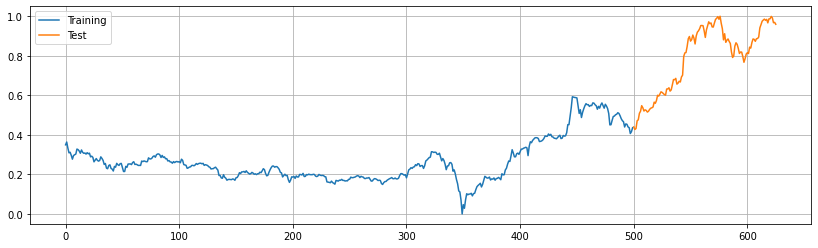

In [147]:
plt.figure(figsize=(14,4))
plt.plot(range(500),y_train)
plt.plot(range(500, len(y)), y_test)
plt.legend(["Training", "Test"])
plt.grid()

In [148]:
X_train = X_train.reshape(-1,1,8)
X_test = X_test.reshape(-1,1,8)

###LSTM

In [163]:
regressor = Sequential()

regressor.add(LSTM(units=32, return_sequences=True, input_shape=(X_train.shape[1],8)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=32, return_sequences=True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=32, return_sequences=True))
regressor.add(Dropout(0.5))

regressor.add(LSTM(units=32))
regressor.add(Dropout(0.5))

regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='adam', loss='mean_absolute_error')
# Fitting to the training set
regressor.fit(X_train, y_train, epochs=30, batch_size=30)

Epoch 1/30
17/17 [==============================] - 15s 6ms/step - loss: 0.2551
Epoch 2/30
17/17 [==============================] - 0s 6ms/step - loss: 0.1807
Epoch 3/30
17/17 [==============================] - 1s 84ms/step - loss: 0.0895
Epoch 4/30
17/17 [==============================] - 0s 6ms/step - loss: 0.0774
Epoch 5/30
17/17 [==============================] - 0s 6ms/step - loss: 0.0824
Epoch 6/30
17/17 [==============================] - 0s 8ms/step - loss: 0.0755
Epoch 7/30
17/17 [==============================] - 0s 8ms/step - loss: 0.0699
Epoch 8/30
17/17 [==============================] - 0s 7ms/step - loss: 0.0686
Epoch 9/30
17/17 [==============================] - 0s 7ms/step - loss: 0.0569
Epoch 10/30
17/17 [==============================] - 0s 7ms/step - loss: 0.0544
Epoch 11/30
17/17 [==============================] - 0s 7ms/step - loss: 0.0541
Epoch 12/30
17/17 [==============================] - 0s 7ms/step - loss: 0.0486
Epoch 13/30
17/17 [============================

###결과

In [164]:
y_pred = regressor.predict(X_test)

In [165]:
regressor.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_20 (LSTM)               (None, 1, 32)             5248      
_________________________________________________________________
dropout_20 (Dropout)         (None, 1, 32)             0         
_________________________________________________________________
lstm_21 (LSTM)               (None, 1, 32)             8320      
_________________________________________________________________
dropout_21 (Dropout)         (None, 1, 32)             0         
_________________________________________________________________
lstm_22 (LSTM)               (None, 1, 32)             8320      
_________________________________________________________________
dropout_22 (Dropout)         (None, 1, 32)             0         
_________________________________________________________________
lstm_23 (LSTM)               (None, 32)               

Text(0, 0.5, 'Price')

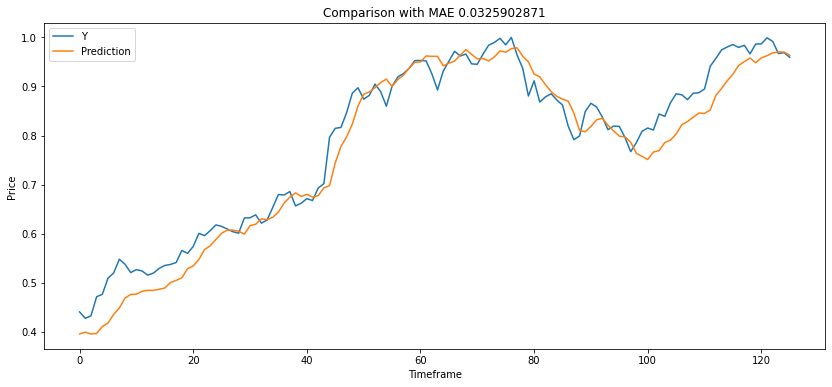

In [166]:
plt.figure(figsize=(14,6))
plt.plot(y_test)
plt.plot(y_pred)
plt.title("Comparison with MAE {0:0.10f}".format(mean_absolute_error(y_test, y_pred)))
plt.legend(["Y", "Prediction"])
plt.xlabel("Timeframe")
plt.ylabel("Price")

In [167]:
err_model3 = regressor.evaluate(X_test, y_test, batch_size=30)

models = pd.DataFrame({
    'Model': ['LSTM with Only Close', 'LSTM with Close, Technical Analysis','LSTM with Close, Technical Analysis, Sentimental Score'],
    'Score': [err_model1,err_model2,err_model3]})
models.sort_values(by='Score', ascending=True)

5/5 [==============================] - 3s 4ms/step - loss: 0.0326


,Model,Score
2,"LSTM with Close, Technical Analysis, Sentiment...",0.032590
1,"LSTM with Close, Technical Analysis",0.089808
0,LSTM with Only Close,0.355256
